# Comprendre la Self-Attention

La self-attention est le mécanisme fondamental qui a révolutionné le traitement du langage naturel avec l'architecture Transformer introduite dans "Attention Is All You Need" (Vaswani et al., 2017).

## Pourquoi l'attention est importante ?

Contrairement aux architectures récurrentes (RNN, LSTM), l'attention permet au modèle de considérer **simultanément** tous les mots d'une séquence, et d'établir des relations directes entre n'importe quels mots, quelle que soit leur distance dans la phrase.

L'idée fondamentale est simple mais puissante :
- Chaque mot "interroge" tous les autres mots pour savoir lesquels sont pertinents pour sa propre représentation
- Les poids d'attention déterminent l'importance relative de chaque mot pour le mot courant
- Cela permet de capturer des dépendances à longue distance de manière efficace

Dans ce notebook, nous allons déconstruire ce mécanisme pour le comprendre de l'intérieur.

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
import os

from model import build_transformer
from config import get_config, get_weights_file_path
from tokenizers import Tokenizer
from dataset import BilingualDataset, causal_mask

# Configuration
config = get_config()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation de: {device}")

# Charger les tokenizers
tokenizer_src = Tokenizer.from_file(config["tokenizer_file"].format(config["lang_src"]))
tokenizer_target = Tokenizer.from_file(config["tokenizer_file"].format(config["lang_target"]))

# Fonction pour charger le modèle à partir d'une époque spécifique
def load_model(epoch):
    model_filename = get_weights_file_path(config, f"{epoch:02d}")
    
    # Construire le modèle
    model = build_transformer(
        tokenizer_src.get_vocab_size(),
        tokenizer_target.get_vocab_size(),
        config["seq_len"],
        config["seq_len"],
        config["d_model"]
    ).to(device)
    
    # Charger les poids
    state_dict = torch.load(model_filename)
    model.load_state_dict(state_dict["model_state_dict"])
    model.eval()
    
    return model

# Fonction pour préparer une phrase d'entrée
def prepare_input(text, tokenizer_src):
    # Tokeniser le texte
    tokens = tokenizer_src.encode(text).ids
    
    # Ajouter SOS, EOS et PAD tokens
    sos_token = tokenizer_src.token_to_id('[SOS]')
    eos_token = tokenizer_src.token_to_id('[EOS]')
    pad_token = tokenizer_src.token_to_id('[PAD]')
    
    # Construire l'entrée de l'encodeur
    tokens = [sos_token] + tokens + [eos_token]
    num_padding = config["seq_len"] - len(tokens)
    
    if num_padding < 0:
        tokens = tokens[:config["seq_len"]-1] + [eos_token]
    else:
        tokens = tokens + [pad_token] * num_padding
    
    # Créer le masque
    encoder_mask = (torch.tensor(tokens) != pad_token).unsqueeze(0).unsqueeze(0).int().to(device)
    # Garder les tokens en type Long pour l'embedding
    encoder_input = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)
    
    return encoder_input, encoder_mask, tokens

# Liste des époques disponibles
available_epochs = []
for file in os.listdir(config["model_folder"]):
    if file.startswith(config["model_basename"]) and file.endswith(".pt"):
        epoch = file[len(config["model_basename"]):-3]
        if epoch.isdigit():
            available_epochs.append(int(epoch))

available_epochs.sort()
print(f"Époques disponibles: {available_epochs}")

# Exemple de phrase pour visualisation
example_text = "I would like to learn more about artificial intelligence."
print(f"Phrase d'exemple: '{example_text}'")

Utilisation de: cuda
Époques disponibles: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Phrase d'exemple: 'I would like to learn more about artificial intelligence.'


## Query, Key, Value : les trois piliers de l'attention

La self-attention repose sur trois composants essentiels, tous dérivés de la même entrée mais servant des fonctions différentes :

### 1. Query (Q) - "Que cherche-t-on ?"
- Pour chaque position, la query représente "ce que cette position recherche"
- C'est comme une question posée par un mot pour savoir quels autres mots sont pertinents

### 2. Key (K) - "Que propose-t-on ?"
- Les keys sont "ce que chaque position offre" aux autres positions
- Elles permettent de déterminer la compatibilité avec les queries

### 3. Value (V) - "Quelle information transmet-on ?"
- Les values contiennent "l'information à extraire" de chaque position
- Elles sont pondérées par les scores d'attention pour former la sortie finale

Le mécanisme fonctionne comme suit :
1. On calcule la similarité entre chaque query et toutes les keys (`Q·K^T`)
2. On normalise ces scores via softmax pour obtenir des poids d'attention
3. On agrège les values en les pondérant par ces poids d'attention

Mathématiquement : `Attention(Q,K,V) = softmax(QK^T/√d_k)·V`

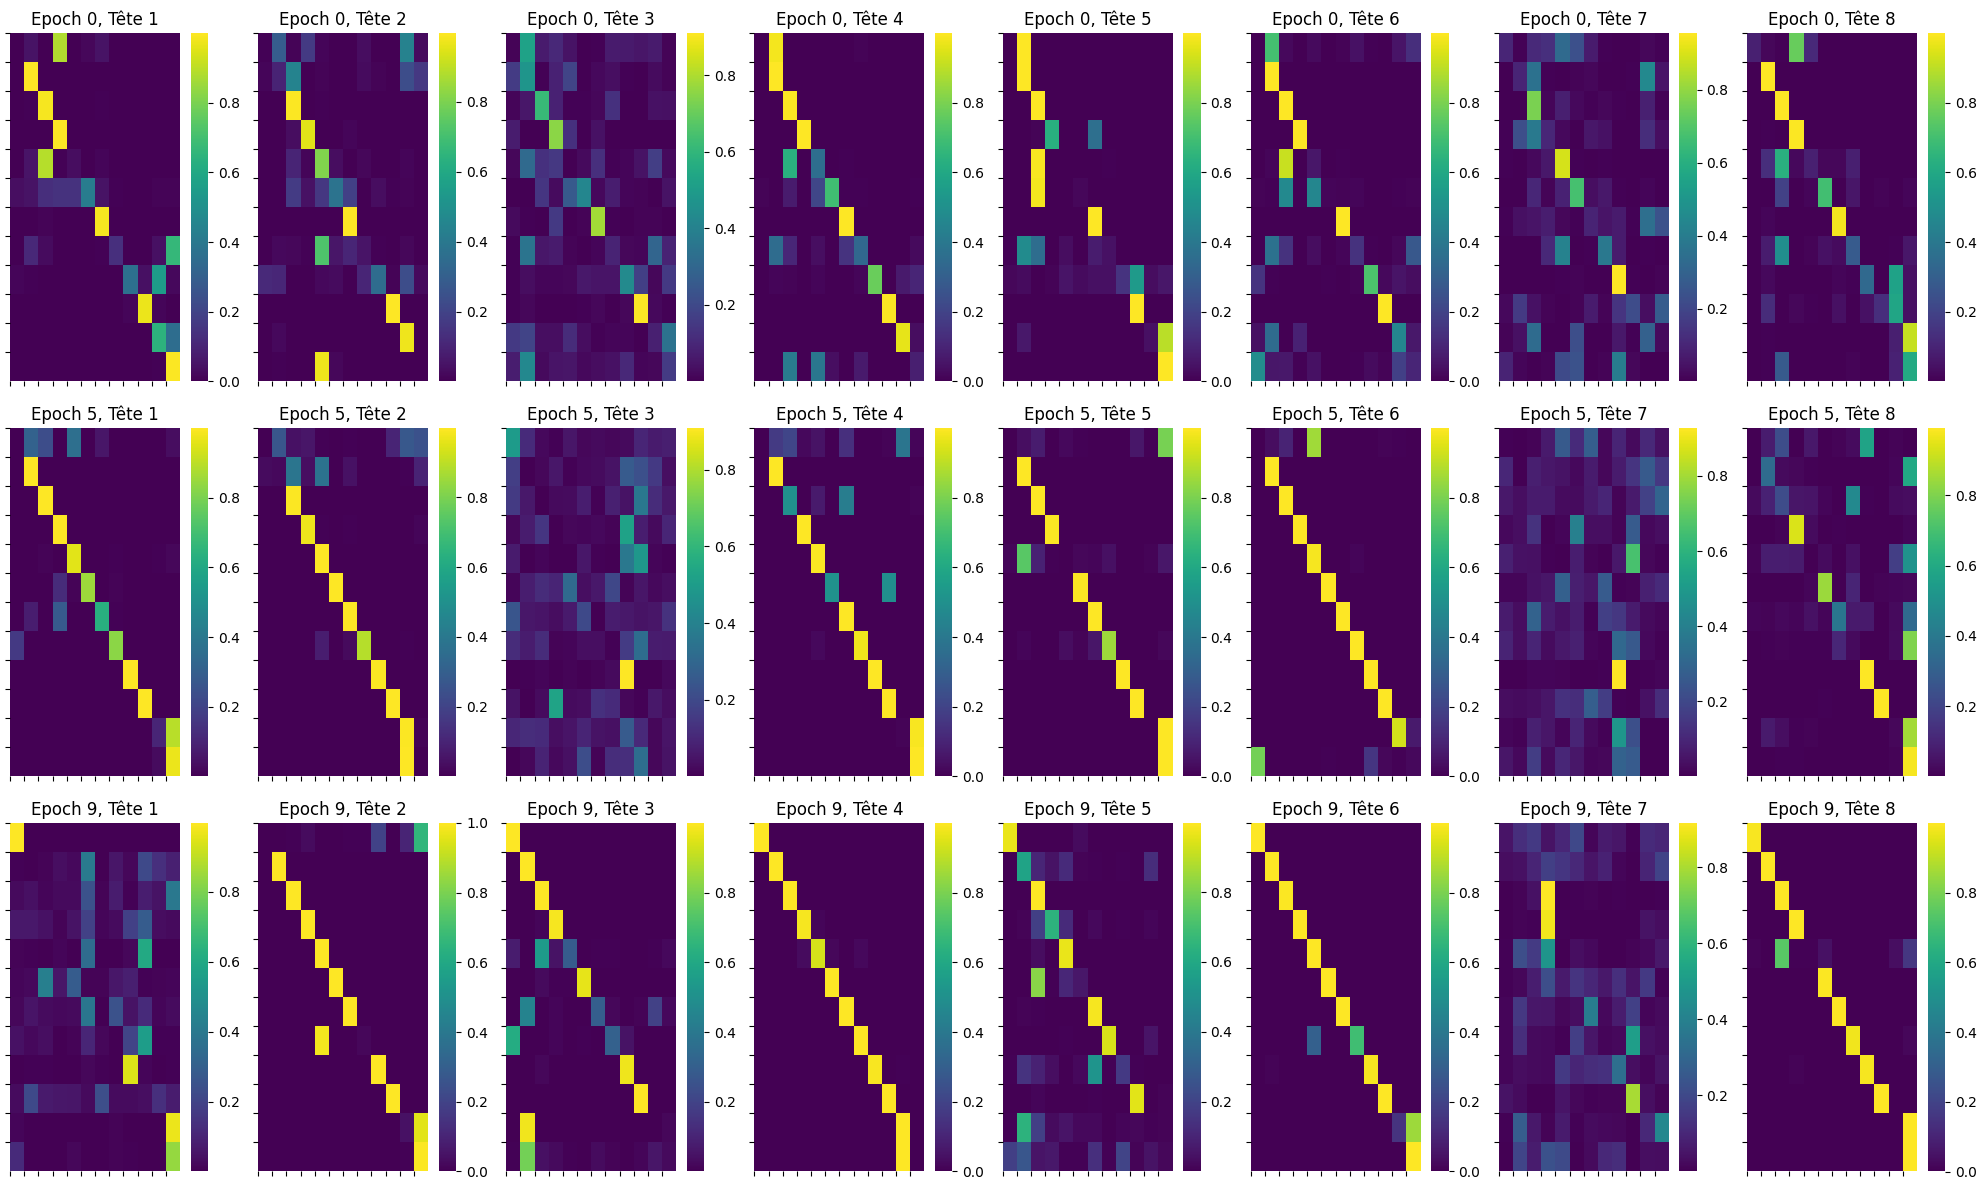

Texte source: I would like to learn more about artificial intelligence.
Traduction générée: Je voudrais bien savoir davantage .


In [10]:
def visualize_attention_evolution(text, epochs=None):
    """
    Visualise l'évolution de l'attention pour une phrase donnée à travers plusieurs époques
    """
    if epochs is None:
        epochs = available_epochs
    
    # Préparer l'entrée
    encoder_input, encoder_mask, tokens = prepare_input(text, tokenizer_src)
    token_texts = [tokenizer_src.id_to_token(t) for t in tokens if t != tokenizer_src.token_to_id('[PAD]')]
    
    # Configuration de la visualisation
    n_epochs = len(epochs)
    n_heads = config["d_model"] // 64  # Généralement 8 têtes pour d_model=512
    fig, axes = plt.subplots(n_epochs, n_heads, figsize=(20, 4*n_epochs))
    
    if n_epochs == 1:
        axes = [axes]
    
    # Pour chaque époque
    for i, epoch in enumerate(epochs):
        model = load_model(epoch)
        
        # Obtenir l'attention
        with torch.no_grad():
            # Convertir les tokens en embeddings d'abord
            embedded_input = model.src_embed(encoder_input)
            
            # Obtenir les scores d'attention du premier bloc d'encodeur
            encoder_block = model.encoder.layers[0]
            x_norm = encoder_block.residual_connections[0].norm(embedded_input)
            attention_block = encoder_block.self_attention_block
            
            # Préparer Q, K, V
            q = attention_block.w_q(x_norm)
            k = attention_block.w_k(x_norm)
            v = attention_block.w_v(x_norm)
            
            # Reshape pour les têtes multiples
            batch_size = q.shape[0]
            q = q.view(batch_size, -1, attention_block.h, attention_block.d_k).transpose(1, 2)
            k = k.view(batch_size, -1, attention_block.h, attention_block.d_k).transpose(1, 2)
            v = v.view(batch_size, -1, attention_block.h, attention_block.d_k).transpose(1, 2)
            
            # Calculer les scores d'attention
            d_k = q.shape[-1]
            scores = (q @ k.transpose(-2, -1)) / np.sqrt(d_k)
            if encoder_mask is not None:
                scores.masked_fill_(encoder_mask == 0, -1e9)
            attention_scores = torch.nn.functional.softmax(scores, dim=-1).cpu().numpy()[0]
        
        # Afficher les scores d'attention pour chaque tête
        for h in range(n_heads):
            # Extraire les scores pertinents (ignorer le padding)
            valid_len = len(token_texts)
            scores_to_plot = attention_scores[h, :valid_len, :valid_len]
            
            # Créer la heatmap
            ax = axes[i][h]
            sns.heatmap(scores_to_plot, 
                        annot=False, 
                        cmap="viridis", 
                        xticklabels=token_texts, 
                        yticklabels=token_texts,
                        ax=ax)
            ax.set_title(f"Epoch {epoch}, Tête {h+1}")
            ax.set_xticklabels(token_texts, rotation=90)
            ax.set_yticklabels(token_texts, rotation=0)
            
            # Ajouter des lignes de grille pour mieux voir les mots
            ax.set_xticks(np.arange(0, len(token_texts)))
            ax.set_yticks(np.arange(0, len(token_texts)))
            ax.grid(False)
    
    plt.tight_layout()
    return fig

# Visualiser l'évolution pour les époques sélectionnées
epochs_to_show = [available_epochs[0], available_epochs[-1]]  # Première et dernière époque
if len(available_epochs) > 2:
    middle_epoch = available_epochs[len(available_epochs)//2]
    epochs_to_show.insert(1, middle_epoch)

fig = visualize_attention_evolution(example_text, epochs=epochs_to_show)
plt.show()

# Fonction pour visualiser l'attention sur une phrase de traduction complète
def visualize_translation_attention(text, epoch=None):
    if epoch is None:
        epoch = available_epochs[-1]  # Utiliser la dernière époque disponible
    
    model = load_model(epoch)
    
    # Préparer l'entrée
    encoder_input, encoder_mask, src_tokens = prepare_input(text, tokenizer_src)
    src_token_texts = [tokenizer_src.id_to_token(t) for t in src_tokens if t != tokenizer_src.token_to_id('[PAD]')]
    
    # Générer une traduction en capturant les scores d'attention
    sos_token = tokenizer_target.token_to_id('[SOS]')
    eos_token = tokenizer_target.token_to_id('[EOS]')
    
    # Commencer avec juste le token SOS
    decoder_input = torch.tensor([[sos_token]]).to(device)
    
    # Encoder la séquence source
    encoder_output = model.encode(encoder_input, encoder_mask)
    
    # Liste pour stocker les tokens générés et les scores d'attention
    output_tokens = []
    attention_maps = []
    
    # Générer la séquence cible
    with torch.no_grad():
        for i in range(config["seq_len"]):
            # Créer le masque causal pour le décodeur
            decoder_mask = causal_mask(decoder_input.size(1)).to(device)
            
            # Passer à travers le décodeur
            decoder_output = model.decode(encoder_output, encoder_mask, decoder_input, decoder_mask)
            
            # Projeter vers le vocabulaire cible
            projection = model.project(decoder_output)
            
            # Prendre le token le plus probable
            next_token = projection[0, -1].argmax().item()
            output_tokens.append(next_token)
            
            # Capturer les scores d'attention cross-attention
            # Nous prenons la première couche de décodeur pour la simplicité
            decoder_block = model.decoder.layers[0]
            cross_attention = decoder_block.cross_attention_block
            
            # Si nous avons atteint EOS, arrêter
            if next_token == eos_token:
                break
                
            # Ajouter le token prédit au décodeur pour la prochaine étape
            decoder_input = torch.cat([decoder_input, torch.tensor([[next_token]]).to(device)], dim=1)
    
    # Convertir les tokens en texte
    output_text = tokenizer_target.decode(output_tokens)
    
    print(f"Texte source: {text}")
    print(f"Traduction générée: {output_text}")
    
    return output_text

# Tester avec notre exemple
translation = visualize_translation_attention(example_text)

# Analyser l'attention pour différents types de phrases
def analyze_attention_patterns():
    test_sentences = [
        "The cat is sleeping on the mat.",  # Phrase simple
        "The cat, which was very old, is sleeping on the mat.",  # Phrase avec relative
        "Although it was raining, he went for a walk.",  # Phrase avec subordination
        "The keys to the cabinet are on the table.",  # Dépendance à longue distance
        "The scientist who invented the vaccine won the Nobel Prize."  # Relation sujet-verbe distante
    ]
    
    for sentence in test_sentences:
        fig = visualize_attention_evolution(sentence, epochs=[available_epochs[-1]])  # Dernière époque
        plt.suptitle(f"Attention pour: '{sentence}'", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()
        
        print("-" * 80)
        translation = visualize_translation_attention(sentence)
        print("-" * 80)
        print("\n")

# Décommenter pour exécuter l'analyse
# analyze_attention_patterns()